In [1]:
#IMPORTING MODULES

import numpy as np
import pandas as pd
import os
from astropy.timeseries import LombScargle
import lightkurve as lk
import matplotlib.pyplot as plt
import shutil
from astropy.utils.data import _get_download_cache_loc

from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs

In [2]:
### PRELIMINARY STUFF

#Raw table
raw_table = pd.read_csv("tess_sector_91_92.csv",skiprows=[0, 1],names=["update_date","main_id","TICID","gaiadr3_id","CCD","Tmag","RA","Dec","sector","count","sp_type","sp_qual","plx_value","V","B","G","otype","nbref","rvz_radvel","rvz_redshift","gaiadr3_plx","gaiadr3phot_g_mean_mag","gaiadr3_bp_rp","abs_mag_rough"])

#Creating scuti line
point_1 = (0.24,2)
point_2 = (0.12,4)

m = (point_1[1]-point_2[1])/(point_1[0] - point_2[0])
b= (point_1[1]-m*point_1[0])
#tolerance = 5 #height of diagonal band
tolerance = 7

#creating boolean mask
raw_table['gaiadr3_bp_rp'] = pd.to_numeric(raw_table['gaiadr3_bp_rp'], errors='coerce')
raw_table['abs_mag_rough'] = pd.to_numeric(raw_table['abs_mag_rough'], errors='coerce')
raw_table.dropna(subset=['gaiadr3_bp_rp', 'abs_mag_rough'], inplace=True)


diagonal_mask = (abs(raw_table['abs_mag_rough'] - (m * raw_table['gaiadr3_bp_rp'] + b)) <= tolerance)

filtered_table = raw_table[diagonal_mask]

#Creating List of Chosen TICIDs
tic_ids = filtered_table['TICID']

id_list = tic_ids.tolist()

int_id_list = [int(f) for f in id_list]

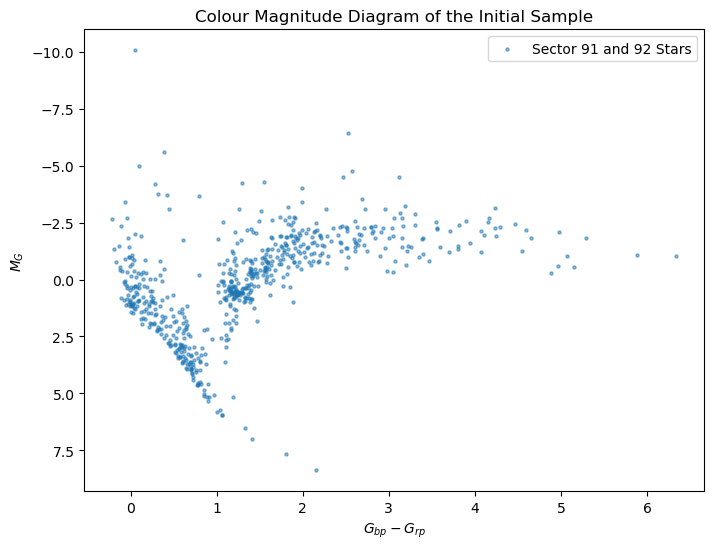

In [5]:
###Plotting All Stars
plt.figure(figsize=(8, 6))
plt.scatter(raw_table['gaiadr3_bp_rp'], raw_table['abs_mag_rough'], s=5, alpha=0.5, label='Sector 91 and 92 Stars')
plt.title("Colour Magnitude Diagram of the Initial Sample")
plt.xlabel(r"$G_{bp} - G_{rp}$")
plt.ylabel(r"$M_{G}$")
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("HRdiagram.png", dpi = 300)
plt.show()


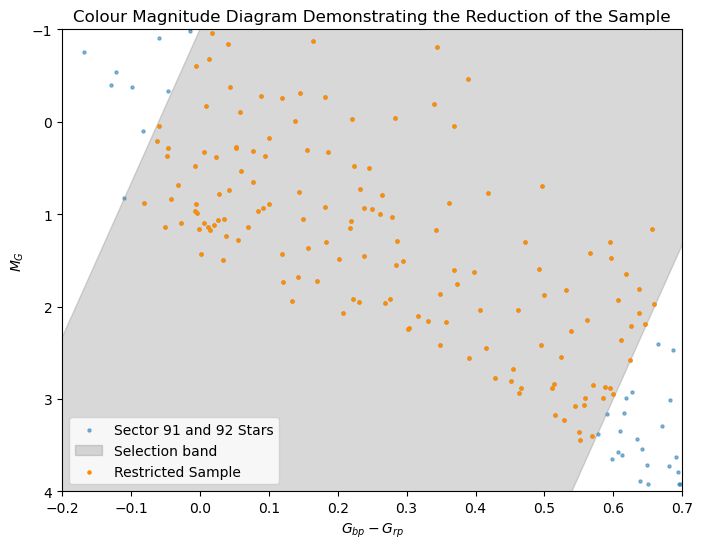

In [6]:
###Visualising the selected region
import matplotlib.pyplot as plt
import numpy as np

# Scatter all stars
plt.figure(figsize=(8, 6))
plt.scatter(raw_table['gaiadr3_bp_rp'], raw_table['abs_mag_rough'], s=5, alpha=0.5, label='Sector 91 and 92 Stars')

# Define range for x (colour)
x_vals = np.linspace(raw_table['gaiadr3_bp_rp'].min(), raw_table['gaiadr3_bp_rp'].max(), 500)

# Define central line and bounds
y_central = m * x_vals + b
y_upper = y_central + tolerance
y_lower = y_central - tolerance

# Plot the scuti band
plt.fill_between(x_vals, y_lower, y_upper, color='grey', alpha=0.3, label='Selection band')

# Plot selected points
plt.scatter(filtered_table['gaiadr3_bp_rp'], filtered_table['abs_mag_rough'], s=5, color='darkorange', label='Restricted Sample')

# Label axes
plt.title("Colour Magnitude Diagram Demonstrating the Reduction of the Sample")
plt.xlabel(r"$G_{bp} - G_{rp}$")
plt.ylabel(r"$M_{G}$")
plt.legend()

plt.ylim(-1,4)
plt.xlim(-0.2,0.7)

# Invert y-axis (since lower magnitude = brighter)
plt.gca().invert_yaxis()
plt.savefig("restricted_sample.png", dpi = 300)
plt.show()


In [7]:
#ADDING dScuti LABEL TO RELEVANT STARS

#label table
label_table = pd.read_csv("stats.csv",skiprows=[0],names=["TICID","Analysed","dScuti","Rpeak"])
label_table["dScuti"] = pd.to_numeric(label_table["dScuti"], errors="coerce").fillna(0).astype(int)

print(label_table)

merged_table = pd.merge(filtered_table, label_table, on="TICID", how="left")

# --- Create mask for dScuti stars ---
dscuti_mask = merged_table["dScuti"] == 1

# --- Extract δ Scuti stars from filtered sample ---
filtered_dscuti_table = merged_table[dscuti_mask]

         TICID  Analysed  dScuti Rpeak
0    175934060       NaN       0   NaN
1    152859121       1.0       0     0
2    178999156       NaN       0   NaN
3     83852015       NaN       0   NaN
4    465992580       NaN       0   NaN
..         ...       ...     ...   ...
659  333075410       1.0       0     0
660    8861923       NaN       0   NaN
661  437413557       NaN       0   NaN
662   24266783       1.0       0     0
663    3205453       NaN       0   NaN

[664 rows x 4 columns]


In [8]:
print(filtered_dscuti_table)

    update_date       main_id        TICID           gaiadr3_id  CCD  Tmag  \
2     10/7/2025   * rho01 Sgr  334177803.0  4084474835781915392  3.0  3.77   
9     10/7/2025     * ksi Aqr  333077513.0  2667335258168556928  4.0  4.55   
10   11/10/2024     * eta Cap  418824772.0  6833190855089866112  2.0  4.64   
11    10/7/2025   * chi01 Sgr  168829745.0  6769709554832595456  4.0  4.71   
23     9/7/2025     *  95 Vir   19924794.0  3615103045677755392  3.0  5.12   
26     9/7/2025     * eta Lib   71859994.0  6262024010760055424  1.0  5.20   
27    10/7/2025     *  18 Aqr  288404080.0  6890965518204449536  1.0  5.22   
29     9/7/2025     *  16 Sco  420896293.0  4348404390042854912  4.0  5.33   
36     9/7/2025     *   4 Sco   77390459.0  6235362022019967232  3.0  5.50   
42    10/7/2025     *  44 Cap  155745933.0  6841731655255386240  3.0  5.64   
49    10/7/2025     *  45 Cap  155772218.0  6838704699744176768  3.0  5.76   
55     9/7/2025     V* HR Lib  410540533.0  6262796555119019392 

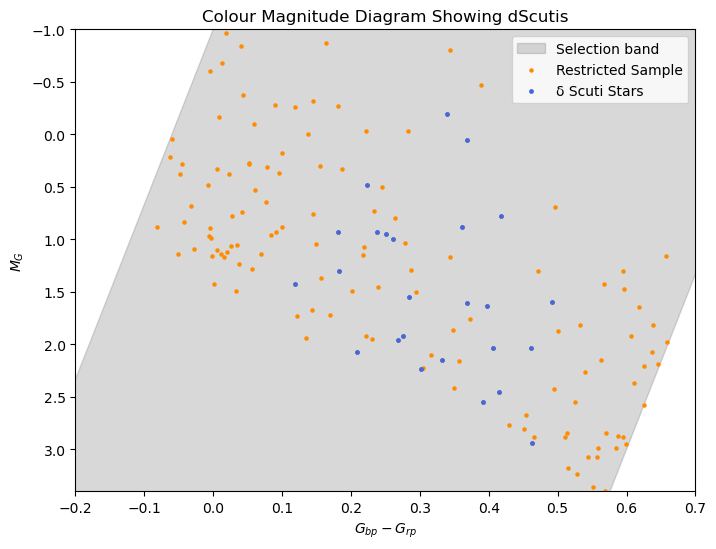

In [9]:
###Plotting
plt.figure(figsize=(8, 6))

# Plot the scuti band
plt.fill_between(x_vals, y_lower, y_upper, color='grey', alpha=0.3, label='Selection band')

# Plot selected points
plt.scatter(filtered_table['gaiadr3_bp_rp'], filtered_table['abs_mag_rough'], s=5, color='darkorange', label='Restricted Sample')

#Plot scutis
plt.scatter(filtered_dscuti_table["gaiadr3_bp_rp"], filtered_dscuti_table["abs_mag_rough"], s=6, color="royalblue", label="δ Scuti Stars")

# Label axes
plt.title("Colour Magnitude Diagram Showing dScutis")
plt.xlabel(r"$G_{bp} - G_{rp}$")
plt.ylabel(r"$M_{G}$")
plt.legend()

plt.ylim(-1,3.4)
plt.xlim(-0.2,0.7)

# Invert y-axis (since lower magnitude = brighter)
plt.gca().invert_yaxis()
plt.savefig("dscuticonfirmed.png",dpi = 300)
plt.show()

In [10]:
###PRELIM ANALYSIS 2

# Make a Python list of TIC IDs for confirmed δ Scuti stars
dscuti_tic_list = filtered_dscuti_table["TICID"].tolist()

#convert to integers
dscuti_tic_list = [int(tic) for tic in dscuti_tic_list]

print(dscuti_tic_list)

[334177803, 333077513, 418824772, 168829745, 19924794, 71859994, 288404080, 420896293, 77390459, 155745933, 155772218, 410540533, 126006658, 70367797, 206144150, 413731775, 73806092, 214611227, 368759, 225709409, 381822792, 259365501, 288143236, 186287370, 49069582]


In [11]:
###Dominant frequency finder

#search function
def selective_search(tic_id):
    search_result = lk.search_lightcurve(f'TIC {tic_id}', mission='TESS')

    if not search_result:
        print(f"⚠️ No TESS light curves found for TIC {tic_id}.")
        return None
    
    try:
        selec_search = search_result[search_result.author == 'SPOC']
        exptimes = selec_search.table['exptime']
        min_index = exptimes.argmin()
        parsed_search = selec_search[min_index]
    except:
        print("No Spoc result found")
        exptimes = search_result.table['exptime']
        min_index = exptimes.argmin()
        parsed_search = search_result[min_index]
        
    return parsed_search

#downloading data and removing bad data points function

def dwnlwd(parsed_search):
    data = parsed_search.download(quality_bitmask='default').remove_nans()
    return data

#Removing Outliers
def outlier_remover(data):
    return data.remove_outliers(5)

#Extracting and normalising data
def extracter(data):
    #.remove_outliers()
    
    time, flux = data.time.value, data.flux.value
    flux /= np.median(flux)
    time -= time[0]

    return time, flux

#Fourier Transform function
def calc_lomb_scargle(t,y):
    oversample = 10 # can be adjusted
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    fmin = df
    fmax = 1000 # set max freq in c/d

    freq = np.arange(fmin, fmax, df / oversample)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct * 1e6
    return freq, amp # freq in cycles per day and amp in ppm

#dom peak picker
def peak_picker(freq,amp):
    min_freq = 10
    max_freq = 60
    valid_mask = (freq > min_freq) & (freq < max_freq)

    freq_high = freq[valid_mask]
    amp_high = amp[valid_mask]

    # Find index of maximum amplitude above cutoff
    peak_index = np.argmax(amp_high)

    dominant_frequency = freq_high[peak_index]
    dominant_period = 1.0 / dominant_frequency

    return dominant_period

#Compiling Function

def period_finder(tic_id):

    parsed_search_result = selective_search(tic_id)

    if parsed_search_result == None:
        return
    
    data = dwnlwd(parsed_search_result)

    data_stripped = outlier_remover(data)

    time, flux = extracter(data_stripped)

    freq, amp = calc_lomb_scargle(time, flux)

    dom_period = peak_picker(freq,amp)
    
    return dom_period


In [12]:
#testing
print(1/period_finder(259365501))

17.227962206430643


In [13]:
### fund freq line (barac et al)

#FUNDAMENTAL PERIOD

def fund_period(abs_mag):
    period = 10**((abs_mag + 1.4)/(-3.01))

    return period #in days

/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_25914/3830531325.py:58: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_25914/3830531325.py:58: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_25914/3830531325.py:58: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_25914/3830531325.py:58: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6


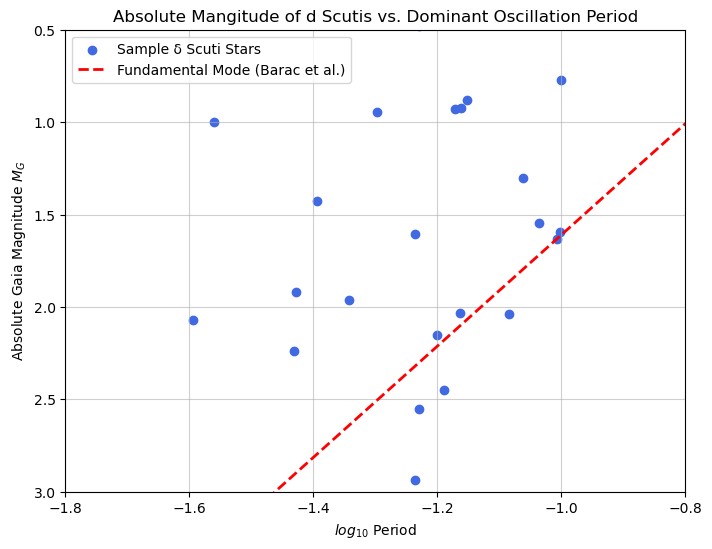

In [14]:
### plotting PM Relation

# Create lists to store results
log_periods = []
abs_mags = []
valid_ticids = []

# Loop through δ Scuti TIC IDs
for tic in dscuti_tic_list:
    try:
        dom_period = period_finder(tic)
        if dom_period is not None:
            log_periods.append(np.log10(dom_period))
            abs_mag = filtered_dscuti_table.loc[filtered_dscuti_table["TICID"] == tic, "abs_mag_rough"].values[0]
            abs_mags.append(abs_mag)
            valid_ticids.append(tic)
    except Exception as e:
        print(f"⚠️ Skipped TIC {tic}: {e}")

# Convert to numpy arrays for plotting
log_periods = np.array(log_periods)
abs_mags = np.array(abs_mags)

# --- Plot δ Scuti stars ---
plt.figure(figsize=(8, 6))
plt.scatter(log_periods, abs_mags, color="royalblue", label="Sample δ Scuti Stars")

# --- Add fundamental frequency line ---
# Create range of absolute magnitudes covering your sample
abs_mag_range = np.linspace(abs_mags.min() - 0.5, abs_mags.max() + 0.5, 200)

# Compute fundamental-mode periods and convert to log10
fund_periods = fund_period(abs_mag_range)
log_fund_periods = np.log10(fund_periods)

# Plot the line
plt.plot(log_fund_periods, abs_mag_range, color="red", lw=2, ls="--", label="Fundamental Mode (Barac et al.)")

# --- Style the plot ---
plt.gca().invert_yaxis()  # brighter (lower M) at top
plt.xlabel(r"$log_{10}$ Period")
plt.ylabel(r"Absolute Gaia Magnitude $M_{G}$")
plt.title("Absolute Mangitude of d Scutis vs. Dominant Oscillation Period")
plt.legend()
plt.ylim(3,0.5)
plt.xlim(-1.8,-0.8)
plt.grid(True, ls="-", alpha=0.6)
plt.savefig("PLrelation.png")
plt.show()


In [15]:
print(log_periods)

[-1.15184492 -1.2973248  -1.17224338 -1.43203268 -1.00234871 -1.20050938
 -1.16339545 -1.1625747  -1.22985427 -1.07328173 -1.43202319 -1.23027586
 -1.23620688 -1.06194367 -1.42781558 -1.39420464 -1.03580915 -1.00009362
 -1.00652209 -1.594916   -1.18965085 -1.23623391 -1.08437028 -1.34297076
 -1.56103134]
